In [14]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input
from tensorflow.keras.models import Model

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    x = Conv1D(64, 15, padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(128, 15, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(256, 15, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(512, 15, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1DTranspose(256, 15, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1DTranspose(128, 15, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1DTranspose(64, 15, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(x)
    
    return Model(inp, out)

generator = build_generator()

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Extend and add noise to ECG segments using the SNR formula
def add_noise_to_segments(ecg_segments, noise_signal, target_snr_db):
    noisy_segments = []
    noise_signal = extend_noise_signal(noise_signal, ecg_segments.shape[1])
    
    for ecg_segment in ecg_segments:
        current_snr = calculate_snr(ecg_segment, noise_signal[:len(ecg_segment)])
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function
def denoise_signal(generator, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = generator.predict(noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # You may want to use more features from different levels

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight=class_weight_dict)
    clf.fit(features, labels)
    return clf

# Create combined noise types
combined_noises = {
    'EM+MA': em_noise + ma_noise,
    'EM+BW': em_noise + bw_noise,
    'MA+BW': ma_noise + bw_noise,
    'EM+BW+MA': em_noise + bw_noise + ma_noise
}

# Add single noises to combined noises
noises = {
    'EM': em_noise,
    'BW': bw_noise,
    'MA': ma_noise
}
noises.update(combined_noises)

snr_db = 0  # Example SNR value

results = {}

for noise_name, noise_data in noises.items():
    noisy_ecg_slices = add_noise_to_segments(ecg_segments, noise_data, snr_db)
    denoised_ecg_slices = denoise_signal(generator, noisy_ecg_slices)
    
    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices])
    
    train_labels = mapped_labels[:len(features_noisy)]
    
    model_noisy = classify_heartbeats(features_noisy, train_labels)
    model_denoised = classify_heartbeats(features_denoised, train_labels)
    
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)
    
    # Get the unique classes present in train_labels
    unique_classes = np.unique(train_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]
    
    # Evaluate accuracy for each class
    report_noisy = classification_report(train_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(train_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)
    
    # Store accuracy for each class
    results[noise_name] = {
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names}
    }

# Output the results for each class and noise condition
for noise_name, metrics in results.items():
    print(f"Noise type: {noise_name}")
    print("Noisy data accuracies:")
    for class_label, accuracy in metrics['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in metrics['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")


C:\Python3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


756/756 ━━━━━━━━━━━━━━━━━━━━ 161s 213ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 173s 229ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 174s 230ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 174s 230ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 173s 229ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 173s 229ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 173s 229ms/step
Noise type: EM
Noisy data accuracies:
  N: 0.9966
  V: 0.7190
  A: 0.0709
  L: 0.9242
Denoised data accuracies:
  N: 0.9876
  V: 0.6036
  A: 0.0226
  L: 0.3090


Noise type: BW
Noisy data accuracies:
  N: 0.9973
  V: 0.7502
  A: 0.0668
  L: 0.9297
Denoised data accuracies:
  N: 0.9873
  V: 0.6690
  A: 0.0301
  L: 0.3627


Noise type: MA
Noisy data accuracies:
  N: 0.9968
  V: 0.7400
  A: 0.0688
  L: 0.9451
Denoised data accuracies:
  N: 0.9829
  V: 0.4419
  A: 0.0123
  L: 0.2920


Noise type: EM+MA
Noisy data accuracies:
  N: 0.9966
  V: 0.7254
  A: 0.0697
  L: 0.9238
Denoised data accuracies:
  N: 0.9869
  V: 0.5878
  A: 0.0226
  L: 0.3044


Noise type: EM+BW
Noisy data accur

C:\Python3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


756/756 ━━━━━━━━━━━━━━━━━━━━ 454s 600ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 515s 681ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 669s 885ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 722s 954ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 843s 1s/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 453s 599ms/step
Noise type: EM
Average SNR after denoising: 13.6108 dB
Average RMSE after denoising: 0.5302
Noisy data accuracies:
  N: 0.9966
  V: 0.7190
  A: 0.0709
  L: 0.9242
Denoised data accuracies:
  N: 0.9888
  V: 0.5528
  A: 0.0579
  L: 0.5379


Noise type: BW
Average SNR after denoising: 12.5450 dB
Average RMSE after denoising: 0.4977
Noisy data accuracies:
  N: 0.9973
  V: 0.7502
  A: 0.0668
  L: 0.9297
Denoised data accuracies:
  N: 0.9923
  V: 0.5860
  A: 0.0550
  L: 0.5229


Noise type: MA
Average SNR after denoising: 12.2609 dB
Average RMSE after denoising: 0.5105
Noisy data accuracies:
  N: 0.9968
  V: 0.7400
  A: 0.0688
  L: 0.9451
Denoised data accuracies:
  N: 0.9883
  V: 0.5356


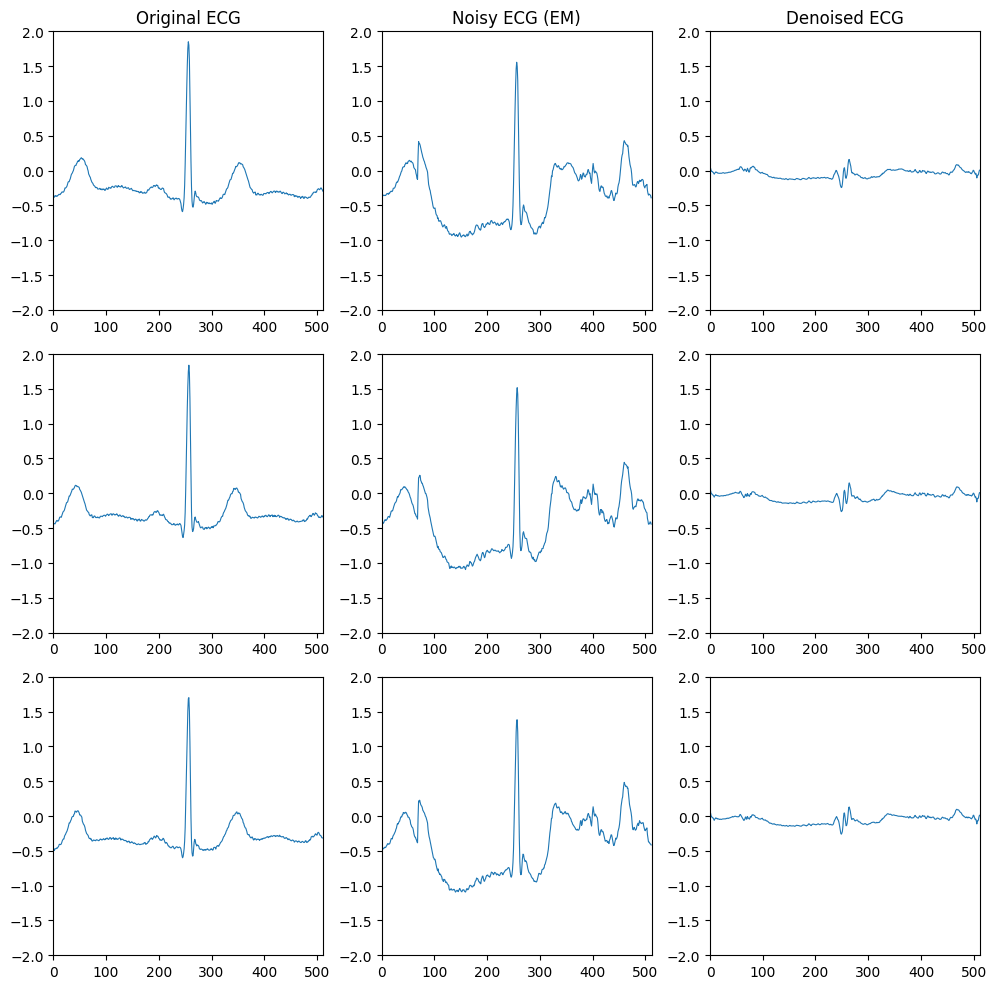

756/756 ━━━━━━━━━━━━━━━━━━━━ 420s 555ms/step


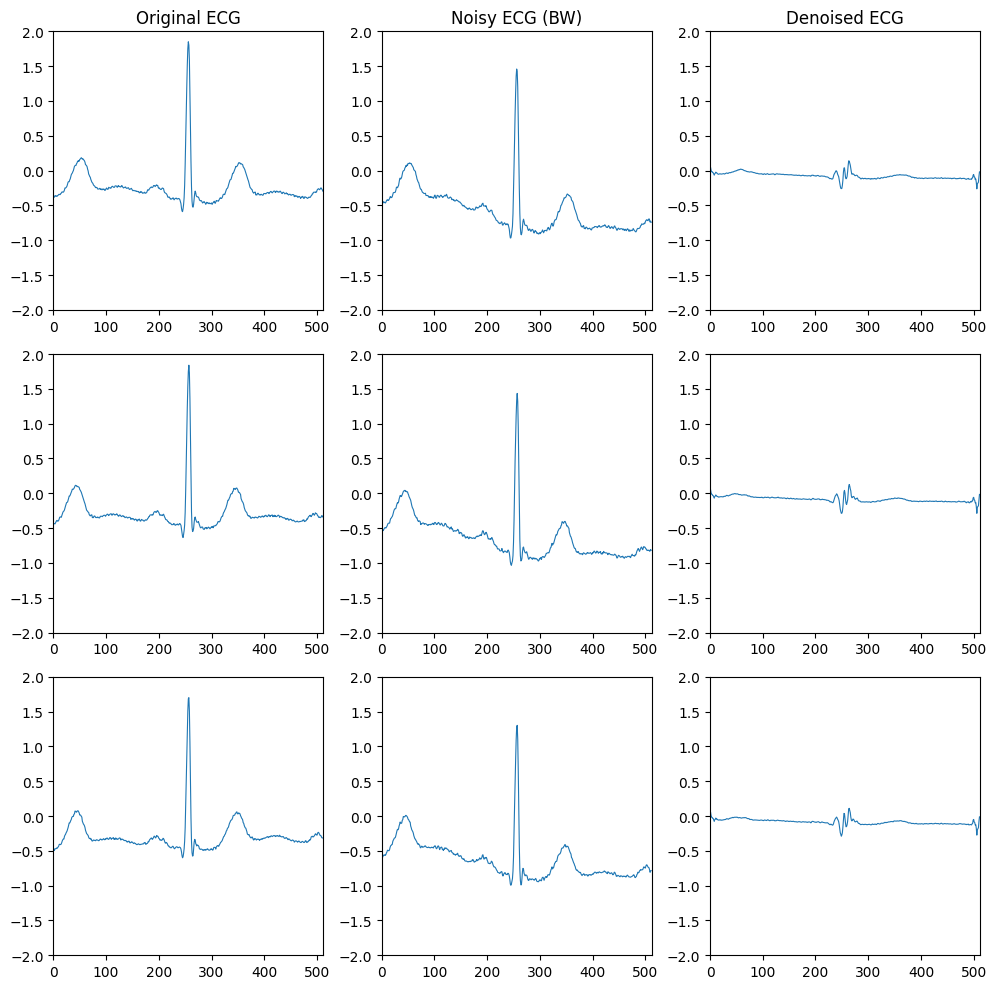

756/756 ━━━━━━━━━━━━━━━━━━━━ 718s 951ms/step


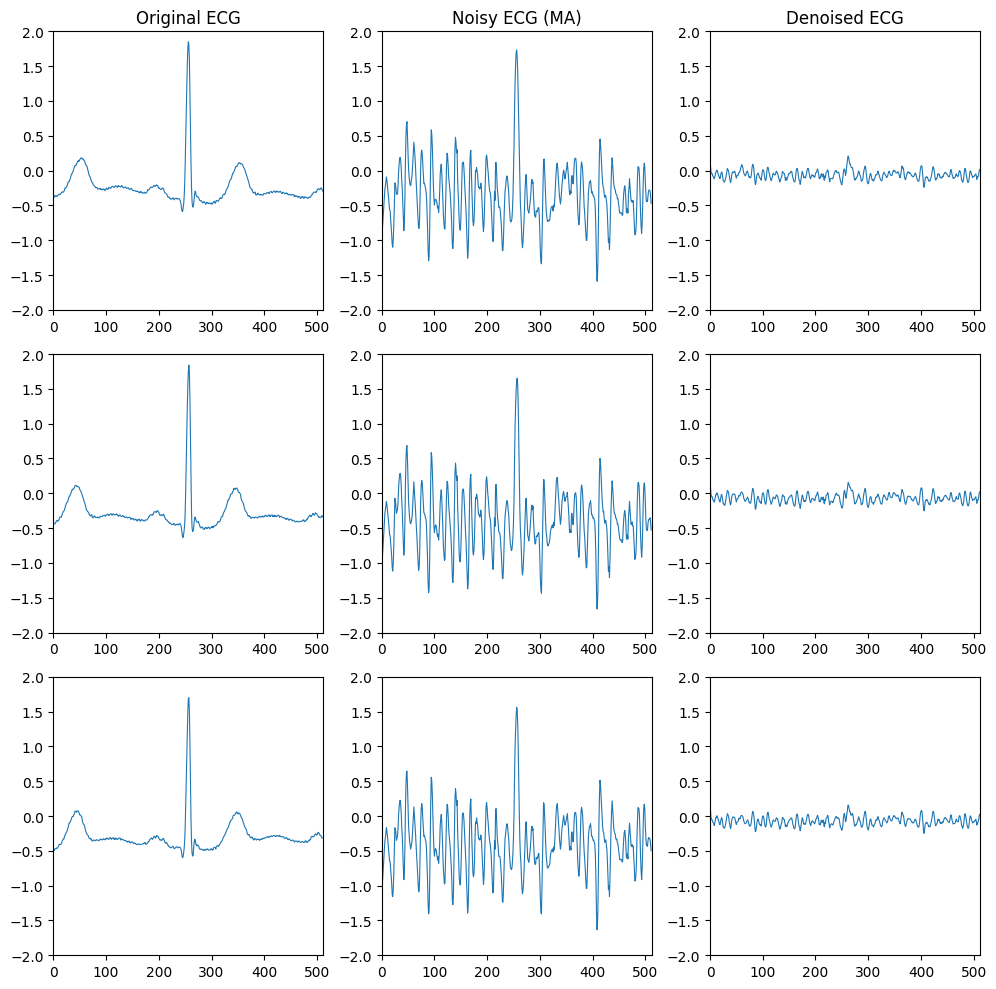

756/756 ━━━━━━━━━━━━━━━━━━━━ 748s 989ms/step


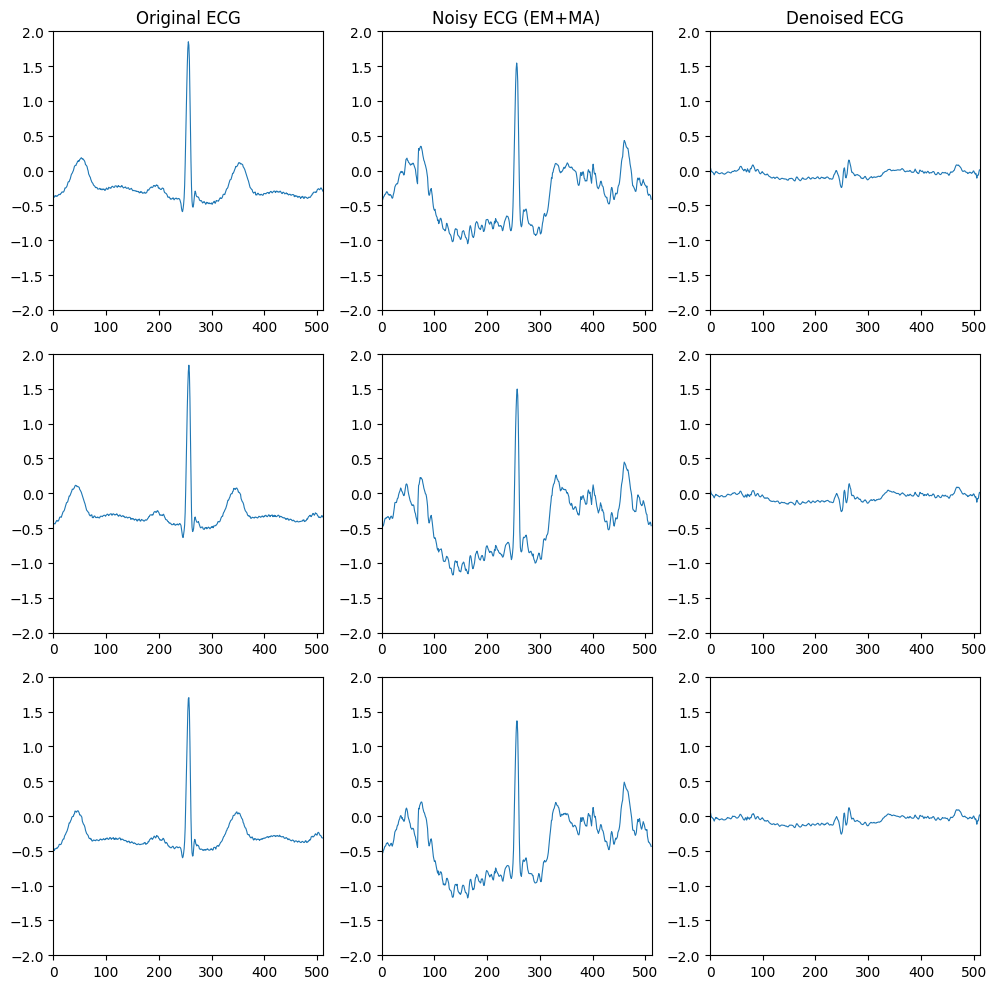

756/756 ━━━━━━━━━━━━━━━━━━━━ 764s 1s/step


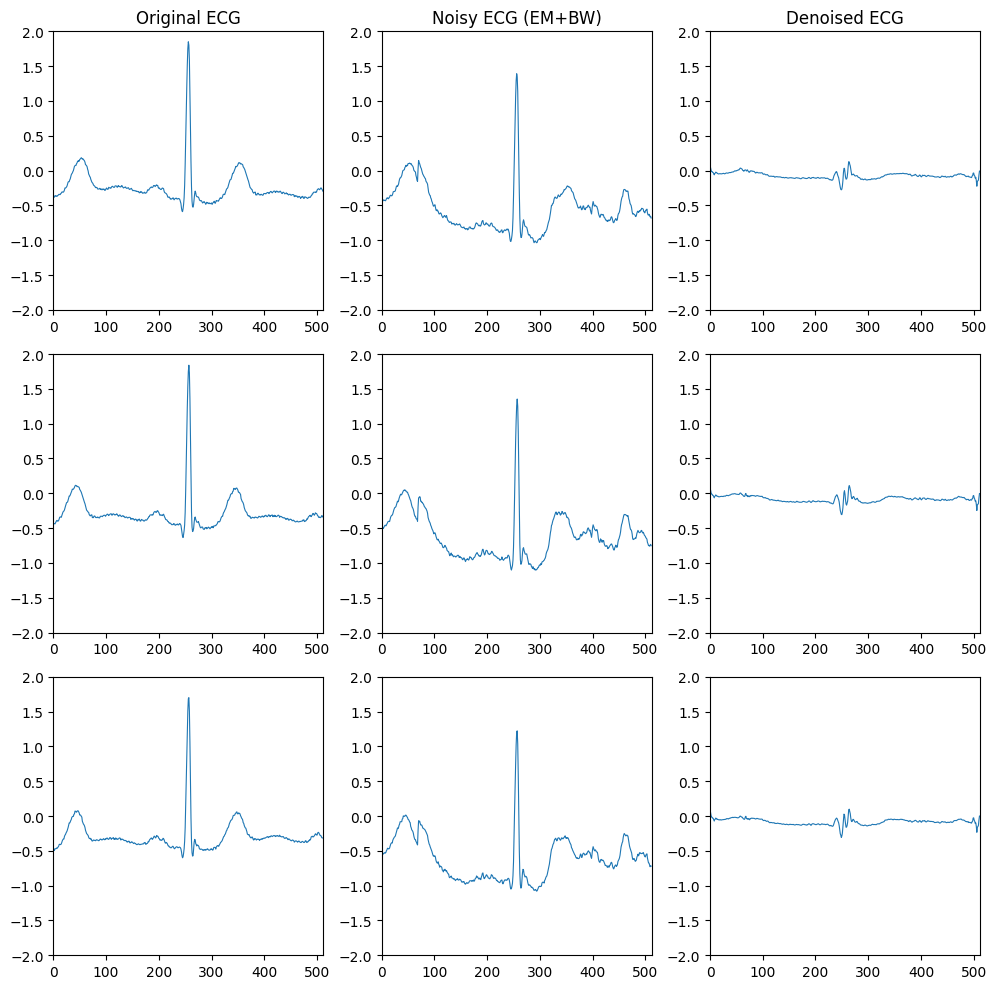

756/756 ━━━━━━━━━━━━━━━━━━━━ 703s 930ms/step


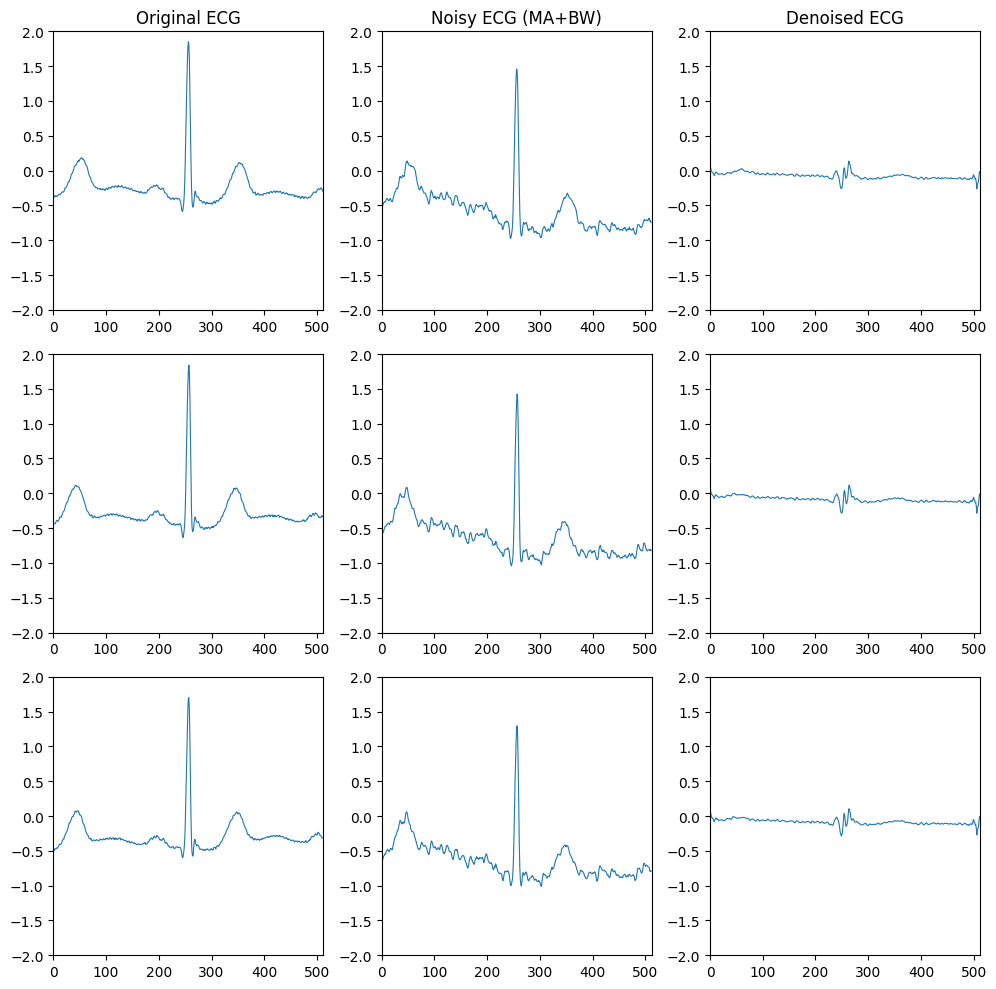

756/756 ━━━━━━━━━━━━━━━━━━━━ 454s 600ms/step


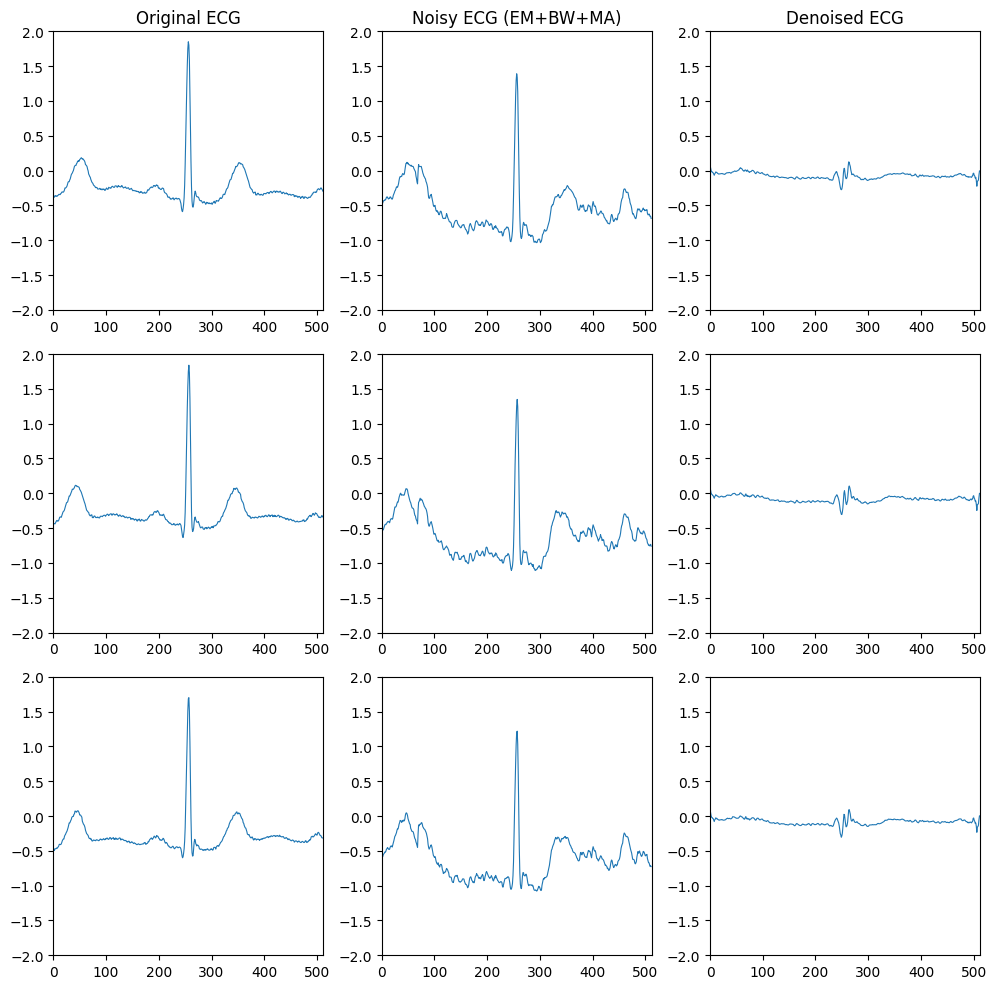

In [4]:
import wfdb
import numpy as np
import pywt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Conv1DTranspose, LeakyReLU, Input, Add
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Load ECG data with correct labels from the MIT-BIH Arrhythmia Database
def load_ecg_data_with_labels(record_numbers, segment_length=512):
    ecg_segments = []
    labels = []
    for rec_num in record_numbers:
        record = wfdb.rdrecord(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}')
        annotation = wfdb.rdann(f'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0/{rec_num}', 'atr')
        
        for i in range(len(annotation.sample)):
            start = max(0, annotation.sample[i] - segment_length // 2)
            end = min(len(record.p_signal), start + segment_length)
            if end - start == segment_length:
                ecg_segments.append(record.p_signal[start:end, 0])  # Assuming MLII lead
                labels.append(annotation.symbol[i])
    
    return np.array(ecg_segments), np.array(labels)

# Load noise data from the correct directory and filenames
def load_noise_data():
    em = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\em', sampfrom=0).p_signal[:, 0]
    bw = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\bw', sampfrom=0).p_signal[:, 0]
    ma = wfdb.rdrecord(r'M:\\Dissertation\\New folder\\mit-bih-noise-stress-test-database-1.0.0\\ma', sampfrom=0).p_signal[:, 0]
    return em, bw, ma

# Instantiate the generator model with skip connections
def build_generator(input_shape=(512, 1)):
    inp = Input(shape=input_shape)

    # Encoder
    x1 = Conv1D(64, 15, padding='same')(inp)
    x1 = LeakyReLU(alpha=0.2)(x1)

    x2 = Conv1D(128, 15, padding='same')(x1)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x3 = Conv1D(256, 15, padding='same')(x2)
    x3 = LeakyReLU(alpha=0.2)(x3)

    x4 = Conv1D(512, 15, padding='same')(x3)
    x4 = LeakyReLU(alpha=0.2)(x4)

    # Decoder with skip connections
    x5 = Conv1DTranspose(256, 15, padding='same')(x4)
    x5 = LeakyReLU(alpha=0.2)(x5)
    x5 = Add()([x5, x3])

    x6 = Conv1DTranspose(128, 15, padding='same')(x5)
    x6 = LeakyReLU(alpha=0.2)(x6)
    x6 = Add()([x6, x2])

    x7 = Conv1DTranspose(64, 15, padding='same')(x6)
    x7 = LeakyReLU(alpha=0.2)(x7)
    x7 = Add()([x7, x1])

    out = Conv1DTranspose(1, 15, padding='same', activation='tanh')(x7)
    
    return Model(inp, out)

generator = build_generator()

# Load ECG and noise data
ecg_records = [103, 105, 111, 116, 122, 205, 213, 219, 223, 230]  # Add more records as needed
ecg_segments, labels = load_ecg_data_with_labels(ecg_records)
em_noise, bw_noise, ma_noise = load_noise_data()

# Filter and map labels to integer categories
label_mapping = {'N': 0, 'V': 1, 'A': 2, 'L': 3}
mapped_labels = np.array([label_mapping.get(label, -1) for label in labels])
valid_indices = mapped_labels != -1

ecg_segments = ecg_segments[valid_indices]
mapped_labels = mapped_labels[valid_indices]

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(mapped_labels), y=mapped_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Extend and add noise to ECG segments
def extend_noise_signal(noise_signal, target_length):
    repeated_noise = np.tile(noise_signal, int(np.ceil(target_length / len(noise_signal))))
    return repeated_noise[:target_length]

def calculate_snr(signal, noise):
    signal_power = np.sum(np.square(signal))
    noise_power = np.sum(np.square(noise))
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def calculate_rmse(signal, denoised_signal):
    return np.sqrt(np.mean((signal - denoised_signal) ** 2))

# Extend and add noise to ECG segments using the SNR formula
def add_noise_to_segments(ecg_segments, noise_signal, target_snr_db):
    noisy_segments = []
    noise_signal = extend_noise_signal(noise_signal, ecg_segments.shape[1])
    
    for ecg_segment in ecg_segments:
        current_snr = calculate_snr(ecg_segment, noise_signal[:len(ecg_segment)])
        scaling_factor = np.sqrt(np.sum(np.square(ecg_segment)) / (np.sum(np.square(noise_signal)) * 10**(target_snr_db / 10)))
        scaled_noise = noise_signal[:len(ecg_segment)] * scaling_factor
        noisy_segment = ecg_segment + scaled_noise
        noisy_segments.append(noisy_segment)
    return np.array(noisy_segments)

# Denoise function
def denoise_signal(generator, noisy_signal):
    noisy_signal = np.expand_dims(noisy_signal, axis=-1)
    denoised_signal = generator.predict(noisy_signal)
    return denoised_signal.squeeze()

# Function to extract wavelet features
def extract_wavelet_features(ecg_slice):
    coeffs = pywt.wavedec(ecg_slice, 'db6', level=5)
    return coeffs[0]  # You may want to use more features from different levels

# Function to classify heartbeats using SVM
def classify_heartbeats(features, labels):
    clf = SVC(kernel='linear', class_weight=class_weight_dict)
    clf.fit(features, labels)
    return clf

# Create combined noise types
combined_noises = {
    'EM+MA': em_noise + ma_noise,
    'EM+BW': em_noise + bw_noise,
    'MA+BW': ma_noise + bw_noise,
    'EM+BW+MA': em_noise + bw_noise + ma_noise
}

# Add single noises to combined noises
noises = {
    'EM': em_noise,
    'BW': bw_noise,
    'MA': ma_noise
}
noises.update(combined_noises)

snr_db = 0  # Example SNR value

results = {}

for noise_name, noise_data in noises.items():
    noisy_ecg_slices = add_noise_to_segments(ecg_segments, noise_data, snr_db)
    denoised_ecg_slices = denoise_signal(generator, noisy_ecg_slices)
    
    # Calculate SNR and RMSE
    snr_values = [calculate_snr(ecg, denoised) for ecg, denoised in zip(ecg_segments, denoised_ecg_slices)]
    rmse_values = [calculate_rmse(ecg, denoised) for ecg, denoised in zip(ecg_segments, denoised_ecg_slices)]
    
    features_noisy = np.array([extract_wavelet_features(slice) for slice in noisy_ecg_slices])
    features_denoised = np.array([extract_wavelet_features(slice) for slice in denoised_ecg_slices])
    
    train_labels = mapped_labels[:len(features_noisy)]
    
    model_noisy = classify_heartbeats(features_noisy, train_labels)
    model_denoised = classify_heartbeats(features_denoised, train_labels)
    
    predictions_noisy = model_noisy.predict(features_noisy)
    predictions_denoised = model_denoised.predict(features_denoised)
    
    # Get the unique classes present in train_labels
    unique_classes = np.unique(train_labels)
    class_names = [name for i, name in enumerate(['N', 'V', 'A', 'L']) if i in unique_classes]
    
    # Evaluate accuracy for each class
    report_noisy = classification_report(train_labels, predictions_noisy, target_names=class_names, output_dict=True, zero_division=0)
    report_denoised = classification_report(train_labels, predictions_denoised, target_names=class_names, output_dict=True, zero_division=0)
    
    # Store accuracy and SNR, RMSE for each class
    results[noise_name] = {
        'noisy': {class_name: report_noisy[class_name]['precision'] for class_name in class_names},
        'denoised': {class_name: report_denoised[class_name]['precision'] for class_name in class_names},
        'snr': np.mean(snr_values),
        'rmse': np.mean(rmse_values)
    }

# Output the results for each class and noise condition
for noise_name, metrics in results.items():
    print(f"Noise type: {noise_name}")
    print(f"Average SNR after denoising: {metrics['snr']:.4f} dB")
    print(f"Average RMSE after denoising: {metrics['rmse']:.4f}")
    print("Noisy data accuracies:")
    for class_label, accuracy in metrics['noisy'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("Denoised data accuracies:")
    for class_label, accuracy in metrics['denoised'].items():
        print(f"  {class_label}: {accuracy:.4f}")
    print("\n")

# Plotting function for the noisy and denoised ECG signals
def plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices, num_samples=3):
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        # Plot original ECG
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.plot(ecg_segments[i], linewidth=0.8)
        if i == 0:
            plt.title('Original ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(ecg_segments[i])])

        # Plot noisy ECG
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.plot(noisy_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title(f'Noisy ECG ({noise_name})')
        plt.ylim([-2, 2])
        plt.xlim([0, len(noisy_ecg_slices[i])])

        # Plot denoised ECG
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.plot(denoised_ecg_slices[i], linewidth=0.8)
        if i == 0:
            plt.title('Denoised ECG')
        plt.ylim([-2, 2])
        plt.xlim([0, len(denoised_ecg_slices[i])])

    plt.tight_layout()
    plt.show()

# Plotting for all noise types
for noise_name, noise_data in noises.items():
    noisy_ecg_slices = add_noise_to_segments(ecg_segments, noise_data, snr_db)
    denoised_ecg_slices = denoise_signal(generator, noisy_ecg_slices)
    
    # Generate plots
    plot_ecg_signals(noise_name, ecg_segments, noisy_ecg_slices, denoised_ecg_slices)
